In [1]:
# data manipulation
import pandas as pd
import numpy as np

# pre processing
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

# model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.neural_network import MLPClassifier

# metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

# plotting
import matplotlib.pyplot as plt

# saving
import joblib

In [2]:
X_train = joblib.load('data/X_train_preprocessed.pkl')
X_test = joblib.load('data/X_test_preprocessed.pkl')
y_train = joblib.load('data/y_train_preprocessed.pkl')
y_test = joblib.load('data/y_test_preprocessed.pkl')

In [3]:
scoring = {
    'accuracy': 'accuracy',
    'precision_macro': make_scorer(precision_score, average='macro'),
    'recall_macro': make_scorer(recall_score, average='macro'),
    'f1_macro': make_scorer(f1_score, average='macro')
}

In [4]:
mlp = MLPClassifier(max_iter=1000)
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [5]:
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],  
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'learning_rate_init': [0.001, 0.01, 0.1]
}

In [10]:
def train_grid_search(X, y, estimator, grid):
    grid_search = GridSearchCV(
        estimator=estimator,
        param_grid=grid,
        cv=skf,
        scoring=scoring,
        refit='f1_macro',
        n_jobs=-1,
        return_train_score=True,
        verbose=1
    )

    grid_search.fit(X, y)

    return grid_search

In [11]:
def get_results(g_search):
    results = pd.DataFrame(g_search.cv_results_)
    
    results = results[
        [
            'mean_fit_time', 'mean_score_time', 'param_hidden_layer_sizes', 'param_activation', 'param_solver',
            'param_alpha', 'param_learning_rate', 'param_learning_rate_init', 'mean_train_accuracy', 'mean_test_accuracy', 'rank_test_accuracy', 'mean_train_precision_macro', 
            'mean_test_precision_macro', 'rank_test_precision_macro', 'mean_train_recall_macro', 'mean_test_recall_macro', 
            'rank_test_recall_macro', 'mean_train_f1_macro', 'mean_test_f1_macro', 'rank_test_f1_macro'
        ]
    ]

    results = results.sort_values(by='mean_test_f1_macro', ascending=False)
    return results

In [12]:
pd.set_option('display.max_columns', None)

In [13]:
grid_search = train_grid_search(X_train, y_train, mlp, param_grid)
results = get_results(grid_search)

Fitting 10 folds for each of 648 candidates, totalling 6480 fits


In [15]:
results.head(200)

,mean_fit_time,mean_score_time,param_hidden_layer_sizes,param_activation,param_solver,param_alpha,param_learning_rate,param_learning_rate_init,mean_train_accuracy,mean_test_accuracy,rank_test_accuracy,mean_train_precision_macro,mean_test_precision_macro,rank_test_precision_macro,mean_train_recall_macro,mean_test_recall_macro,rank_test_recall_macro,mean_train_f1_macro,mean_test_f1_macro,rank_test_f1_macro
0,2.993701,0.016971,"(50,)",relu,adam,0.0001,constant,0.001,1.0,1.0,1,1.0,1.0,1,1.0,1.0,1,1.0,1.0,1
384,4.873094,0.024608,"(100,)",tanh,adam,0.01,invscaling,0.001,1.0,1.0,1,1.0,1.0,1,1.0,1.0,1,1.0,1.0,1
381,5.588934,0.025795,"(100,)",tanh,sgd,0.01,constant,0.01,1.0,1.0,1,1.0,1.0,1,1.0,1.0,1,1.0,1.0,1
380,3.306572,0.028094,"(100,)",tanh,adam,0.01,constant,0.01,1.0,1.0,1,1.0,1.0,1,1.0,1.0,1,1.0,1.0,1
379,19.603451,0.018298,"(100,)",tanh,sgd,0.01,constant,0.001,1.0,1.0,1,1.0,1.0,1,1.0,1.0,1,1.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467,11.354450,0.020065,"(100,)",logistic,sgd,0.0001,adaptive,0.1,1.0,1.0,1,1.0,1.0,1,1.0,1.0,1,1.0,1.0,1
465,18.330982,0.018575,"(100,)",logistic,sgd,0.0001,adaptive,0.01,1.0,1.0,1,1.0,1.0,1,1.0,1.0,1,1.0,1.0,1
464,2.696169,0.018845,"(100,)",logistic,adam,0.0001,adaptive,0.01,1.0,1.0,1,1.0,1.0,1,1.0,1.0,1,1.0,1.0,1
463,61.286628,0.020351,"(100,)",logistic,sgd,0.0001,adaptive,0.001,1.0,1.0,1,1.0,1.0,1,1.0,1.0,1,1.0,1.0,1


In [16]:
def view_test_metrics(train_metrics: bool, filter_top_n: int, results_df: pd.DataFrame):
    if train_metrics:
        metrics = [
            "mean_train_accuracy", "mean_test_accuracy",
            "mean_train_precision_macro", "mean_test_precision_macro",
            "mean_train_recall_macro", "mean_test_recall_macro",
            "mean_train_f1_macro", "mean_test_f1_macro"
        ]
    else:
        metrics = [
            "mean_test_accuracy",
            "mean_test_precision_macro",
            "mean_test_recall_macro",
            "mean_test_f1_macro"
        ]

    if filter_top_n:
        results_df = results_df.nsmallest(filter_top_n, "rank_test_f1_macro")

    param_cols = ['param_hidden_layer_sizes', 'param_activation', 'param_solver', 'param_alpha', 'param_learning_rate', 'param_learning_rate_init']
    plot_df = results_df.melt(
        id_vars=param_cols,      # keep these columns "as is"
        value_vars=metrics,      # the columns we want to "unpivot"
        var_name="metric",       # new column with the metric name
        value_name="score"       # new column with the metric value
    )

    plt.figure(figsize=(12, 8))


    for combo, group in plot_df.groupby(param_cols):
        # Sort the group by metric name (if desired)
        group = group.sort_values("metric")
        # Create a label for this parameter combination
        label_str = ", ".join(f"{col}={val}" for col, val in zip(param_cols, combo))
        
        # Separate train and test metrics using .str.startswith on the 'metric' column
        train_group = group[group["metric"].str.startswith("mean_train")]
        test_group = group[~group["metric"].str.startswith("mean_train")]

        # Plot training metrics with a dashed line and an 'x' marker (with transparency)
        if not train_group.empty:
            plt.plot(train_group["metric"], train_group["score"], 
                     marker='x', linestyle='dashed', alpha=0.7,
                     label=label_str + " (train)")
        # Plot test metrics with a solid line and an 'o' marker (with transparency)
        if not test_group.empty:
            plt.plot(test_group["metric"], test_group["score"], 
                     marker='o', linestyle='solid', alpha=0.7,
                     label=label_str + " (test)")

    plt.xlabel("Metric")
    plt.ylabel("Score")
    plt.title("Comparison of Mean Test Metrics")
    plt.xticks(rotation=45)
    # Adjust the legend to avoid cluttering the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.tight_layout()
    plt.show()  

C:\Users\caiop\AppData\Local\Temp\ipykernel_19324\475445105.py:58: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


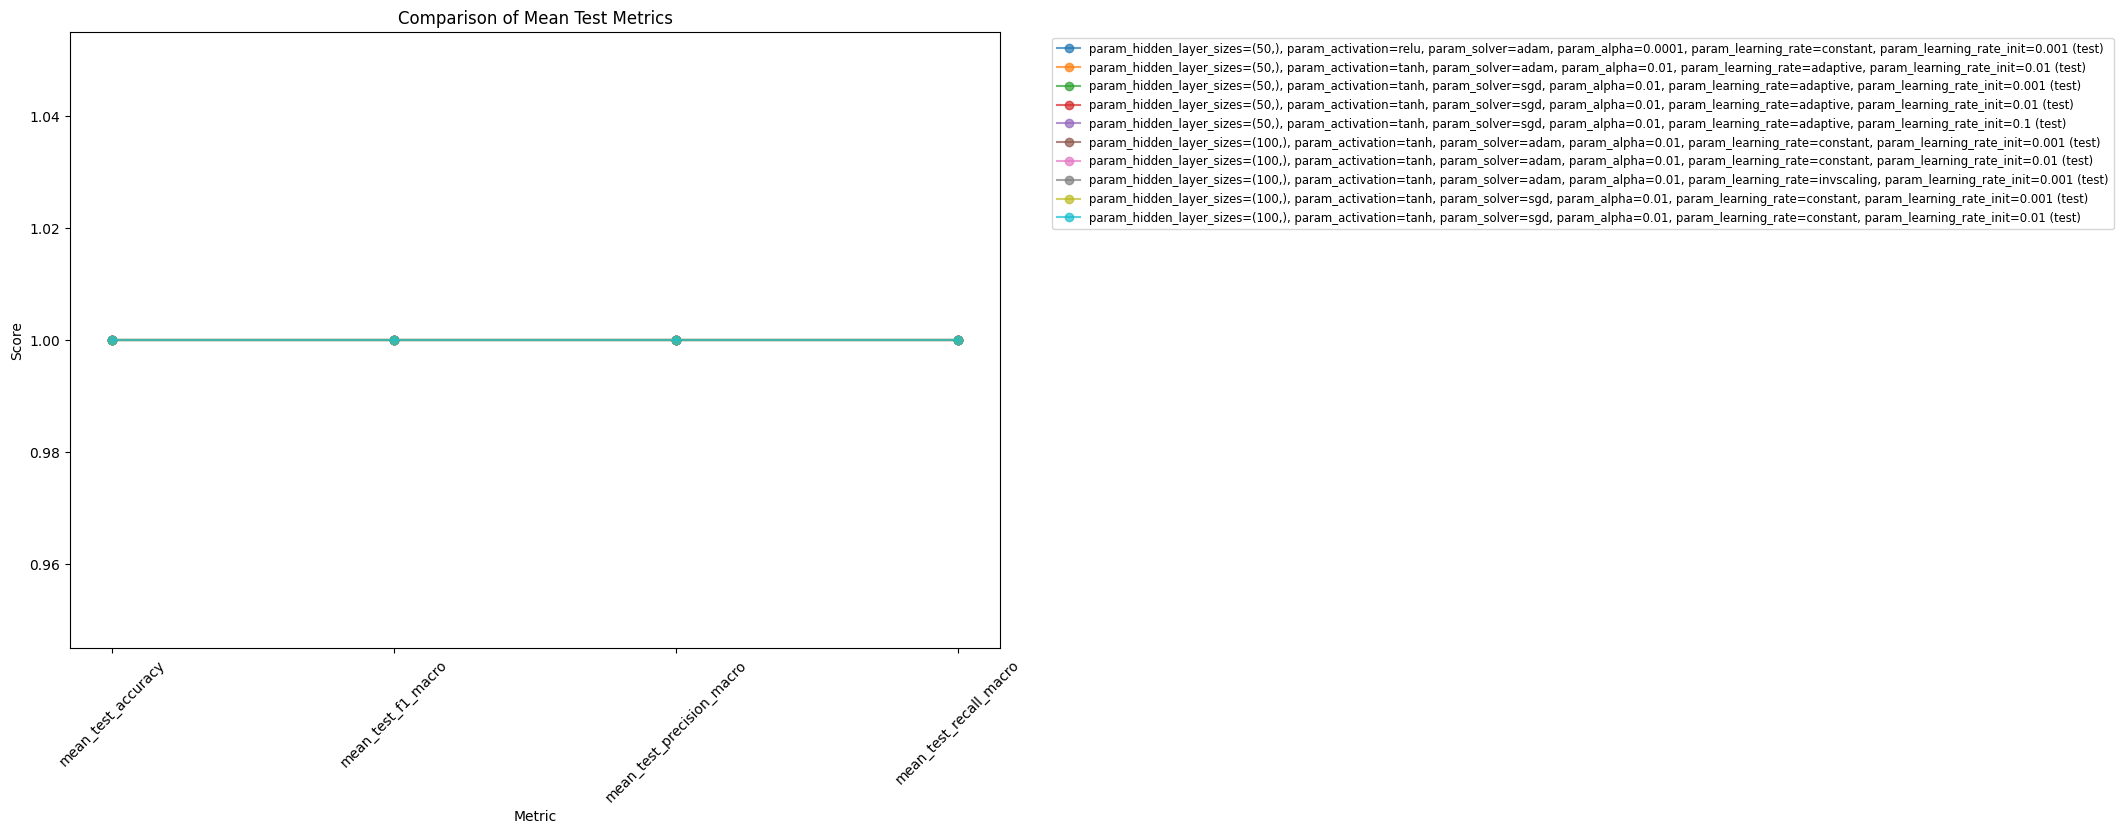

In [17]:
view_test_metrics(False, 10, results)

In [18]:
preds = cross_val_predict(grid_search.best_estimator_, X_train, y_train, cv=skf, n_jobs=-1)

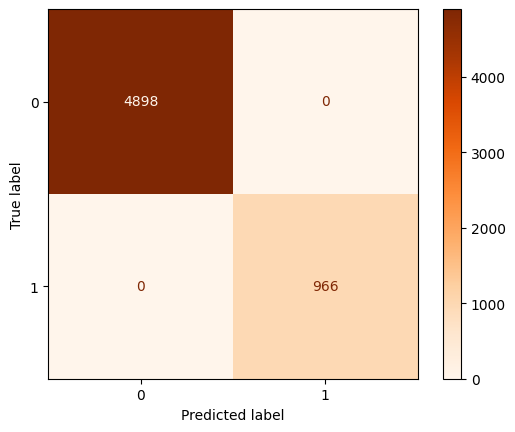

In [19]:
cm = confusion_matrix(y_train, preds)
cmd = ConfusionMatrixDisplay(cm, display_labels=grid_search.best_estimator_.classes_)
cmd.plot(cmap=plt.cm.Oranges)
plt.show()

In [20]:
print(classification_report(y_train, preds, digits=4))

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      4898
           1     1.0000    1.0000    1.0000       966

    accuracy                         1.0000      5864
   macro avg     1.0000    1.0000    1.0000      5864
weighted avg     1.0000    1.0000    1.0000      5864



In [21]:
joblib.dump(grid_search.best_estimator_, 'models/mlp.pkl')

['models/mlp.pkl']